300×3 DataFrame
 Row │ operation  length  time      
     │ Any        Any     Any       
─────┼──────────────────────────────
   1 │ naive      50      0.0003102
   2 │ better     50      0.0003071
   3 │ BLAS       50      0.0002049
   4 │ naive      50      0.0003249
   5 │ better     50      0.0001929
   6 │ BLAS       50      2.11e-5
   7 │ naive      50      0.000316
   8 │ better     50      0.0001966
   9 │ BLAS       50      3.01e-5
  10 │ naive      50      0.0003098
  11 │ better     50      0.0002401
  12 │ BLAS       50      4.18e-5
  13 │ naive      50      0.000335
  14 │ better     50      0.0002505
  15 │ BLAS       50      7.94e-5
  16 │ naive      50      0.000667
  17 │ better     50      0.0002171
  18 │ BLAS       50      3.19e-5
  19 │ naive      50      0.0003753
  20 │ better     50      0.0002004
  21 │ BLAS       50      3.49e-5
  22 │ naive      50      0.0033366
  23 │ better     50      0.000223
  24 │ BLAS       50      4.37e-5
  25 │ naive      50      0

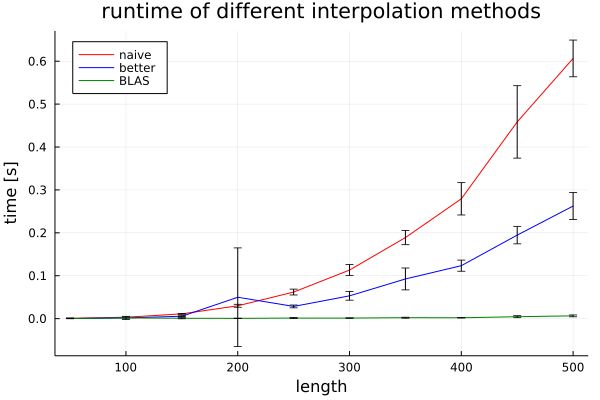

In [5]:
#zadanie 1
using Plots
using Random
using DataFrames
using Statistics

function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

function better_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

operation = []
length = []
time = []

tmp1 = @elapsed naive_multiplication(rand(2, 2), rand(2, 2))
tmp2 = @elapsed better_multiplication(rand(2, 2), rand(2, 2))
tmp3 = @elapsed rand(2, 2) * rand(2, 2)

for i in 1:10
    for j in 1:10
        A = rand(50*i, 50*i)
        B = rand(50*i, 50*i)
        push!(operation, "naive")
        push!(length, 50*i)
        push!(time, @elapsed naive_multiplication(A, B))
        push!(operation, "better")
        push!(length, 50*i)
        push!(time, @elapsed better_multiplication(A, B))
        push!(operation, "BLAS")
        push!(length, 50*i)
        push!(time, @elapsed A*B)
    end
end

df = DataFrame(operation = operation, length = length, time = time)
print(df)
df1 = df[df.operation .== "naive", :]
df1 = groupby(df1, [:length])
df1 = combine(df1, "time" => mean, "time" => std)
df2 = df[df.operation .== "better", :]
df2 = groupby(df2, [:length])
df2 = combine(df2, "time" => mean, "time" => std)
df3 = df[df.operation .== "BLAS", :]
df3 = groupby(df3, [:length])
df3 = combine(df3, "time" => mean, "time" => std)
plot([df1.length df2.length df3.length], [df1.time_mean df2.time_mean df3.time_mean],
title = "runtime of different interpolation methods",
xlab = "length", ylab = "time [s]",
label = ["naive" "better" "BLAS"],
yerr = [df1.time_std df2.time_std df3.time_std],
colour = [:red :blue :green],
legend = :topleft)


#zadanie 2
```c
#include <stdio.h>
#include <stdlib.h>
#include <gsl/gsl_blas.h>
#include <sys/time.h>
#include <time.h>

void naive_multiplication(double** A, double** B, double** C, int len){
    for(int i = 0; i<len; i++){
        for(int j = 0; j<len; j++){
            for(int l = 0; l<len; l++){
                C[i][j] += A[i][l] * B[l][j];
            }
        }
    }
}

void better_multiplication(double** A, double** B, double** C, int len){
    for(int i = 0; i<len; i++){
        for(int l = 0; l<len; l++){
            for(int j = 0; j<len; j++){
                C[i][j] += A[i][l] * B[l][j];
            }
        }
    }
}

void blas(double* A, double* B, double* C, int len){
    gsl_matrix_view a = gsl_matrix_view_array(A, len, len);
    gsl_matrix_view b = gsl_matrix_view_array(A, len, len);
    gsl_matrix_view c = gsl_matrix_view_array(C, len, len);
    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &a.matrix, &b.matrix, 0.0, &c.matrix);
}

double** zeros2d(int len){
    double** C = (double**)calloc(len, sizeof(double*));
    for(int i = 0; i<len; i++){
        double* t = (double*)calloc(len, sizeof(double));
        C[i] = t;
        for(int j = 0; j<len; j++){
            C[i][j] = 0.0;
        }
    }
    return C;
}

double** random2d(int len){
    double** C = (double**)calloc(len, sizeof(double*));
    for(int i = 0; i<len; i++){
        double* t = (double*)calloc(len, sizeof(double));
        C[i] = t;
        for(int j = 0; j<len; j++){
            C[i][j] = (double)rand();
        }
    }
    return C;
}

void free_array2d(double** A, int len){
    for(int i = 0; i<len; i++){
        free(A[i]);
    }
    free(A);
}

double* zeros1d(int len){
    double* A = (double*)calloc(len*len, sizeof(double));
    for(int i = 0; i<len*len; i++){
        A[i] = 0.0;
    }
    return A;
}

double* random1d(int len){
    double* A = (double*)calloc(len*len, sizeof(double));
    for(int i = 0; i<len*len; i++){
        A[i] = (double)rand();
    }
    return A;
}

int main(int argc, char* args[]){
    srand(time(NULL));
    FILE* f = fopen("results.csv", "w");
    fputs("operation,length,time\n", f);
    double elapsed;
    struct timeval start;
    struct timeval end;
    for(int len = 100; len <= 500; len += 100){
        printf("%d\n", len);
        double** A = random2d(len);
        double** B = random2d(len);
        double* A1 = random1d(len);
        double* B1 = random1d(len);
        double** C1 = zeros2d(len);
        double** C2 = zeros2d(len);
        double* C3 = zeros1d(len);
        for(int i = 0; i<10; i++){
            gettimeofday(&start, NULL);
            naive_multiplication(A, B, C1, len);
            gettimeofday(&end, NULL);
            char* s1 = (char*)calloc(128, sizeof(char));
            elapsed = (end.tv_sec - start.tv_sec) * 1000;
            elapsed += (end.tv_usec - start.tv_usec) / 1000;
            sprintf(s1, "naive,%d,%f\n", len, elapsed);
            fputs(s1, f);
            free(s1);

            gettimeofday(&start, NULL);
            better_multiplication(A, B, C2, len);
            gettimeofday(&end, NULL);
            char* s2 = (char*)calloc(128, sizeof(char));
            elapsed = (end.tv_sec - start.tv_sec) * 1000;
            elapsed += (end.tv_usec - start.tv_usec) / 1000;
            sprintf(s2, "better,%d,%f\n", len, elapsed);
            fputs(s2, f);
            free(s2);

            gettimeofday(&start, NULL);
            blas(A1, B1, C3, len);
            gettimeofday(&end, NULL);
            char* s3 = (char*)calloc(128, sizeof(char));
            elapsed = (end.tv_sec - start.tv_sec) * 1000;
            elapsed += (end.tv_usec - start.tv_usec) / 1000;
            sprintf(s3, "blas,%d,%f\n", len, elapsed);
            fputs(s3, f);
            free(s3);
        }
        free_array2d(A, len);
        free_array2d(B, len);
        free_array2d(C1, len);
        free_array2d(C2, len);
        free(C3);
        free(A1);
        free(B1);
    }
    fclose(f);
    return 0;
}
```

In [7]:
#zadanie 2 cd
using Plots
using DataFrames
using Statistics
using CSV

data = CSV.read("results.csv", delim = ",", DataFrame)
println(data)

149×3 DataFrame
 Row │ naive    100    5.000000 
     │ String7  Int64  Float64  
─────┼──────────────────────────
   1 │ better     100      15.0
   2 │ blas       100       0.0
   3 │ naive      100       5.0
   4 │ better     100      16.0
   5 │ blas       100       0.0
   6 │ naive      100       4.0
   7 │ better     100      59.0
   8 │ blas       100       0.0
   9 │ naive      100       4.0
  10 │ better     100       6.0
  11 │ blas       100       0.0
  12 │ naive      100       4.0
  13 │ better     100      10.0
  14 │ blas       100      11.0
  15 │ naive      100       5.0
  16 │ better     100      24.0
  17 │ blas       100       0.0
  18 │ naive      100       5.0
  19 │ better     100       5.0
  20 │ blas       100       0.0
  21 │ naive      100      34.0
  22 │ better     100       5.0
  23 │ blas       100       0.0
  24 │ naive      100      18.0
  25 │ better     100       4.0
  26 │ blas       100      10.0
  27 │ naive      100      15.0
  28 │ better     100